In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

import warnings
np.random.seed(0)
warnings.filterwarnings('ignore')

In [ ]:
agg_df = pd.read_csv('data/user_lvl_agg.csv')

agg_df["membership_length"].fillna(0, inplace=True)
agg_df["member_flag"] = None
agg_df.loc[agg_df["member_Standard"]==1, "member_flag"] = "Standard"
agg_df.loc[agg_df["member_Elite"]==1, "member_flag"] = "Elite"
agg_df.loc[agg_df["member_Not Member"]==1, "member_flag"] = "Not Member"

## Why Clustering?
In order to enhance the Digital Marketing, and Product Development of XXXX airline, we need to tailor these efforts towards the needs of the various customer segments to better serve them. 

These segments should be created using their booking behavior, encompassing the frequency, channel etc and their trip preferences (geographical, economical, seasonal). 

Clustering helps us in doing just that, finding customer groups based on their similiarities in the metrics mentioned above. The detailed approach, our model explorations and their outcome are expanded on in the sections below.

### Features Used in Clustering
We separate out the categorical and continuous columns as we treat them differently. The categorical columns are indicators of the membership status and the most frequent start and destination of a user's trips. 

In [ ]:
continuous_cols = ['Age', 'BaseFareAmt',
        'discount_code', 'membership_length', 'days_booked_in_advance',
        'upgrade_flag', 'class_Coach', 'class_Discount First Class',
        'class_First Class', 'season_fall', 'season_spring', 'season_summer',
        'season_winter', 'channel_Airport', 'channel_Outside Booking',
        'channel_Reservations Booking', 'channel_SCA Website Booking',
        'channel_SY Vacation', 'channel_Tour Operator Portal',
        'trip_type_multi', 'trip_type_one_way',
        'trip_type_round_trip', 'avg_distance',
        'popular_route_rank_1',
        'popular_route_rank_2', 'popular_route_rank_3', 'popular_route_rank_4',
        'popular_route_rank_5', 'popular_route_rank_6', 'popular_route_rank_7',
        'popular_route_rank_8', 'popular_route_rank_9', 'popular_route_rank_10',
        'group_size', 'weekend_0', 'weekend_1',
        'start_midwest', 'start_northeast', 'start_rockey_mountains',
        'start_southeast', 'start_west_coast', 'end_midwest', 'end_northeast',
        'end_rockey_mountains', 'end_southeast', 'end_west_coast', 'temp_diff']

id_col = ['customer_uid']
categorical_cols = ['start_city','end_city','member_flag']

## Applying PCA
Principal Component Analysis (PCA) is needed as our __47 columns__ continuous columns are highly correlated and may cover the same part of the variance. For instance many of the features are trip frequencies, indicating how many trips a user went on in that category, which can be divided based on the season, the booking channel, the source region or the destination among others. All these factors are correlated as a user who goes on numerous trips is likely to have higher frequencies in many of them. However, they also represent different dimensions of the user behavior and thus, can't be dropped. Thus, We will apply PCA to continuous columns and store the lower dimensional data as an array. Subsequently, we will add the categorical arrays for the calculation of hybrid distances and eventually the clusters.

### Approach
We use a widely accepted threshold of covering 80% of the variance in the data. We start from 1 and keep increasing the number of principal components until the threshold is met after which the iteration stops.

Thereafter, we transform the current feature space using only the principal components, reducing our dimensions from 47 to 20. The transformed continuous features are stored in `users_norm`.

In [ ]:
users_norm = StandardScaler().fit_transform(agg_df[continuous_cols])

exp_variance = 0
VARIANCE_THRESHOLD = 0.8
n_components = 0

# Increasing components until threshold is crossed
while exp_variance < VARIANCE_THRESHOLD:
  n_components += 1
  pca = PCA(n_components=n_components)
  pca.fit(users_norm)
  # cumulative sum of variance explained
  exp_variance = np.sum(pca.explained_variance_ratio_)

print(n_components)

users_norm = pca.transform(users_norm)

20


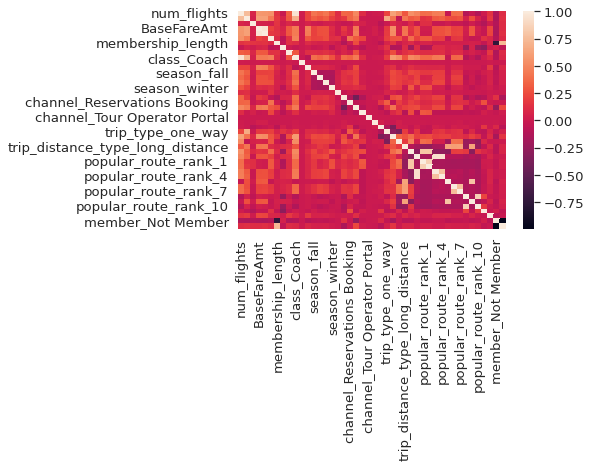

In [ ]:
sns.heatmap(agg_df[continuous_cols].corr())

## Tuning Functions

In order to find the best clustering techniques and the optimal number of clusters, we need to have a consistent basis of comparison. We use the silhoutte scores along with the subjective interpretation of the clusters to decide the best technique and the best number of clusters.

We create a function to generate the silhoutte score for a technique for all the number of clusters ranging from 2 to 10.

In [ ]:
def plot_silhoutte_curve(cluster_class,
                         dist_matrix,
                         data_array=None,
                         start=2,
                         end=10,
                         categorical_cols=None):
    silhouette_score_list =[]
    no_of_clusters = list(range(start, end+1))
    
    for k in no_of_clusters:
      clusterer = cluster_class(k)
      if categorical_cols:
        cls_assignment = clusterer.fit_predict(data_array, categorical=categorical_cols)
      elif data_array is not None:
        cls_assignment = clusterer.fit_predict(data_array)
      else:
        cls_assignment = clusterer.fit_predict(dist_matrix)

      silhouette_avg = silhouette_score(dist_matrix, cls_assignment)
      silhouette_score_list.append(silhouette_avg)

    plt.subplots(figsize=(8,5))
    plt.plot(no_of_clusters, silhouette_score_list)
    plt.title('Silhouette Score', fontsize=18)
    plt.xlabel('Number of Clusters', fontsize=15)
    plt.ylabel('Silhouette', fontsize=15)
    plt.show()
    return silhouette_score_list

## Hybrid Distance Calculation
The next step is to compute the hybrid distances, we use the PCA transformed features (for the continuous columns) and the categorical columns.

We use the gower distance for our calculation as it merges categorical and continuous columns well. We also use a random sample of 15,000 rows of the data as the memory constaraints (16 GB) mean that using more than 15,000 rows with the final 23 features causes a crash.

The distance matrix (with a shape of (15000,15000,20)) is used in subsequent techniques which utilize a distance matrix (such as hierarchical and K-mediods). 

In [ ]:
import gower
SAMPLE_SIZE = 15000

# Memory issues when performing on whole dataset, thus using sampling
sample_idx = np.random.randint(len(users_norm), size=SAMPLE_SIZE)

hybrid_array = np.hstack([users_norm, agg_df[categorical_cols].values])
gower_dist = gower.gower_matrix(hybrid_array[sample_idx])

## K-Mediods

Kmediods is a partion-based technique which uses a distance matrix to calculate which points are closer. The center of the clusters is their median. First we plot the silhoutte curve to see the preferrable number of clusters for this technique. 

We see that the number of clusters: 3, 8, 9, 10 perform the best. However, the clusters should have significant number of users (no on cluster should have too many or too few points) because the recommended business strategies should have enough users to test upon and create significant impact. Thus the final model is trained with `n=3`. We save the assigned cluster columns to the users back into the dataframe for further analysis.

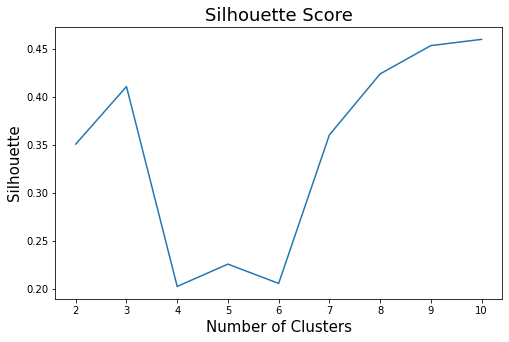

[0.35114667,
 0.41107136,
 0.20289978,
 0.22615181,
 0.2060302,
 0.36074424,
 0.42425337,
 0.45373046,
 0.46024096]

In [ ]:
plot_silhoutte_curve(KMedoids, gower_dist)

In [ ]:
kmed = KMedoids(n_clusters = 3, random_state = 42, method = 'pam') 
kmed.fit(gower_dist)

# Add cluster column
agg_df['kmed_cluster'] =  None
agg_df.loc[sample_idx, 'kmed_cluster'] = kmed.predict(gower_dist)

## Kmeans Clustering 
Since Kmeans clustering only uses the observations of the data and continuous features, we can only use the transformed continuous variables and not the categorical ones. We plot the number of clusters against the Silhouette Score and see that the ideal number of clusters is probably 2 with a 0.141, but there is still much more overlap among the clusters than the Kmediods (which had a score of 0.411).

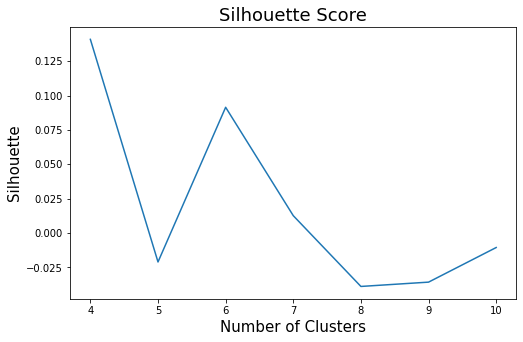

[0.14093734,
 -0.02110581,
 0.09148655,
 0.012597099,
 -0.038918335,
 -0.035779286,
 -0.010585053]

In [ ]:
# Plotting curve for k=2 to k=10
plot_silhoutte_curve(KMeans, data_array=users_norm[sample_idx], dist_matrix=gower_dist)

In [ ]:
kmc = KMeans(n_clusters=2, random_state=42)
kmc.fit(users_norm)
agg_df["kmeans_cluster"] = kmc.labels_

## Hierarchical Clustering
Hierarchical cluster is a bottom up approach, starting out with each point being assigned its own cluster. It uses a distance matrix to determine which are the two closest points and then merges them into one cluster. The aforementioned step is repeated until all the points are part of one single cluster.

We plot the dendrogram to decide the optimal (or natural) number of clusters in the data. The optimal number of clusters is the one after which there needs to be a huge increase/decrease in similiarity (denoted by distance on y-axis) to form another cluster.

Here we see that if we want to make 3, 4 or 5 clusters, the horizontal lines are quite close. Same is the case for creating 6 or 7 clusters. Thus the optimal number of clusters is 6.

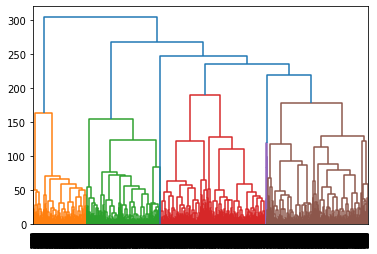

In [ ]:
# Dendrogram based on the hybrid distance
from scipy.cluster.hierarchy import ward, dendrogram
plt.figure()
dendrogram(ward(users_norm[sample_idx]))
plt.show()
# numer of clusters --> 5/6 seems natural

In [ ]:
# taking too much time >40 mins :(
# plot_silhoutte_curve(AgglomerativeClustering, dist_matrix=gower_dist)

In [ ]:
# Running hierarchical clustering with the optimal number of clusters
hc = AgglomerativeClustering(n_clusters=6)

agg_df["hierachical_cluster"] = None
hc.fit(gower_dist)
agg_df.loc[sample_idx, "hierachical_cluster"] = hc.labels_

## KPrototypes
KPrototypes algorithm is also capable of clustering with both column types.  We use the gower distance and our hybrid array to obtain the KPrototype clusters. 

From the silhouette scores we can observe that the optimal number of clusters is 9 for this algorithm (silhoutte score of 0.22). However, we see that the algorithm doesn't perform as well as KMediods (silhoutte score of 0.42) for even for the optimal number of clusters.

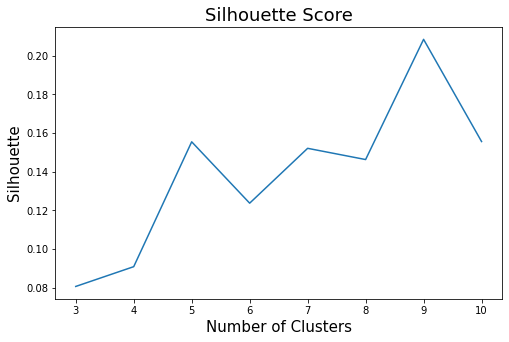

[0.080749795,
 0.09096902,
 0.15547279,
 0.1237702,
 0.15210873,
 0.14630556,
 0.20840101,
 0.15560631]

In [ ]:
cat_col_start = hybrid_array.shape[1]-1-len(categorical_cols)
cat_col_indices = list(range(cat_col_start,hybrid_array.shape[1]))

plot_silhoutte_curve(KPrototypes,
                     dist_matrix=gower_dist,
                     data_array=hybrid_array[sample_idx],
                     categorical_cols=cat_col_indices,
                     start=3)

In [ ]:
kp_model = KPrototypes(n_clusters=9, random_state=42)
kp_model.fit(hybrid_array[sample_idx], categorical=cat_col_indices)

agg_df['kproto_cluster'] =  kp_model.predict(hybrid_array, cat_col_indices)

## Gaussian Mixture Modelling
Gaussian Mixture Modelling has an advantage that it is soft-clustering technique and outputs the likelihood of a point being in a particular cluster rather than a deterministic cluster assignment. However, since Gaussian Mixture Modelling only uses the observations of the data and continuous features, we can only use the transformed continuous variables and not the categorical ones. 

We plot the number of clusters against the Silhouette Score and see that the ideal number of clusters is probably 5 with a score of close to 0, indicating that there is much more overlap among the clusters than the Kmediods ones (which had a score of 0.411).

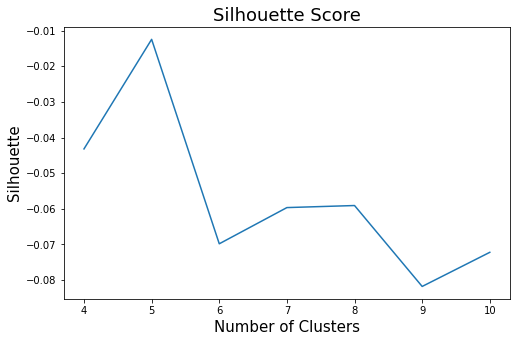

[-0.043197375,
 -0.01245643,
 -0.06981967,
 -0.0596607,
 -0.059084814,
 -0.08178842,
 -0.07220974]

In [ ]:
plot_silhoutte_curve(GaussianMixture,
                     data_array=users_norm[sample_idx],
                     dist_matrix=gower_dist)

In [ ]:
gmm = GaussianMixture(5, random_state=42)
gmm.fit(users_norm)
agg_df["gmm_cluster"] = gmm.predict(users_norm)

In [ ]:
gmm = GaussianMixture(5, random_state=42)
gmm.fit(users_norm)
agg_df["gmm_cluster"] = gmm.predict(users_norm)

## Comparison
In this step we are comparing the SSE and silhoutte scores for each clustering method. We see that Kmediods and Hierarchical clusters far outperform the others. Given that KMediods creates just 3 clusters (with a slightly better silhoutte score) leads us to use it as the final clustering technique.

At the end we are saving the models as a pickle object and each cluster label is saved as a separate column in the data.

In [ ]:
def calculate_silhouette(df, dist_matrix, col_names):
  silhouette_scores = {}
  for col in col_names:
    cluster_labels = df[col]
    silhouette_scores[col] = silhouette_score(dist_matrix, cluster_labels)
  return silhouette_scores

calculate_silhouette(agg_df.loc[sample_idx,:], gower_dist, ["hierachical_cluster","kmed_cluster","kmeans_cluster","kproto_cluster","gmm_cluster"])

{'hierachical_cluster': 0.45203373,
 'kmed_cluster': 0.44706798,
 'kmeans_cluster': 0.079045914,
 'kproto_cluster': 0.17954095,
 'gmm_cluster': 0.1153814}

In [ ]:
def save_model(model, path_prefix="models/"):
  model_path = path_prefix + str(model.__class__).split(".")[-1][:-2]+".pkl"
  with open(model_path, "wb") as f:
      pickle.dump(model, f)
  print("Model saved at: ", model_path)

list(map(save_model,[kmed, hc, kp_model, gmm, kmc]))

In [ ]:
agg_df.to_csv('data/user_with_cluster.csv', index=False)